# Выбор локации для скважины

Допустим, я работаю в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv.

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

# План по выполнению проекта

1. Загрузить и подготовить данные. Поясните порядок действий.
2. Обучить и проверить модель для каждого региона.
3. Подготовиться к расчёту прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
5. Посчитать риски и прибыль для каждого региона.

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from scipy import stats as st 
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

In [2]:
### Константы

In [3]:
#При разведке региона исследуют 500 точек
POINTS_EXP = 500

#Бюджет на разработку скважин в регионе, тыс.руб
BUDGET = 10000000

#Доход с сырья, тыс.руб 
COST_ONE_BAREL = 450

#Порог убытка 2.5%
PERC_RISK = 0.025

### Загрузка данных

In [4]:
link1 = '/datasets/geo_data_0.csv'
link2 = '/datasets/geo_data_1.csv'
link3 = '/datasets/geo_data_2.csv'

if os.path.exists(link1):
    geo_data_0 = pd.read_csv(link1)
else: print('Cсылка на geo_data_0 не действительна')
    
if os.path.exists(link2):
    geo_data_1 = pd.read_csv(link2)
else: print('Cсылка на geo_data_0 не действительна')
    
if os.path.exists(link3):
    geo_data_2 = pd.read_csv(link3)
else: print('Cсылка на geo_data_0 не действительна')

### Анализ данных

In [5]:
#Информация о данных:
def data_info(data, data_name):
    print('Таблица:', data_name)
    print('Размер данных:', data.shape)
    data.info()
    display(data.head())
    #сводная статистика данных
    display(data.describe())
    print('количество дубликатов в таблице: ', data.duplicated().sum() )
    print('количество уникальных id: ', data['id'].nunique(), '\n')

In [6]:
data_info(geo_data_0,' geo_data_0')
data_info(geo_data_1, 'geo_data_1')
data_info(geo_data_2,' geo_data_2')

Таблица:  geo_data_0
Размер данных: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


количество дубликатов в таблице:  0
количество уникальных id:  99990 

Таблица: geo_data_1
Размер данных: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


количество дубликатов в таблице:  0
количество уникальных id:  99996 

Таблица:  geo_data_2
Размер данных: (100000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


количество дубликатов в таблице:  0
количество уникальных id:  99996 



В каждом датафрейме по 10 000 данных, пропуски отсутствуют. Типы данных столбцов соответсвуют информации. Количество уникальных id меньше, чем строк с данными, но дубликатов нет. 

Так как в исходных данных описано, что id - уникальный идентификатор скважины, то, вероятно, эти данные аномальные и их следует удалить. 

In [7]:
#Поиск и удаление аномальных повторяющихся id:
def data_double(data, data_name):
    print('Таблица:', data_name) 
    print('Размер таблицы: ', data.shape)
    print('Количество повторяющихся id: ', data['id'].value_counts()[data['id'].value_counts() >= 2].shape[0])
    list = data['id'].value_counts()[data['id'].value_counts() >= 2].index.to_list()
    for i in list:
        data =  data[data['id'].str.contains(i)== False ]
    print('Размер таблицы после удаления аномальных id: ', data.shape, '\n')
    return data

In [8]:
geo_data_0 = data_double(geo_data_0, 'geo_data_0')
geo_data_1 = data_double(geo_data_1, 'geo_data_1')
geo_data_2 = data_double(geo_data_2, 'geo_data_2')

Таблица: geo_data_0
Размер таблицы:  (100000, 5)
Количество повторяющихся id:  10
Размер таблицы после удаления аномальных id:  (99980, 5) 

Таблица: geo_data_1
Размер таблицы:  (100000, 5)
Количество повторяющихся id:  4
Размер таблицы после удаления аномальных id:  (99992, 5) 

Таблица: geo_data_2
Размер таблицы:  (100000, 5)
Количество повторяющихся id:  4
Размер таблицы после удаления аномальных id:  (99992, 5) 



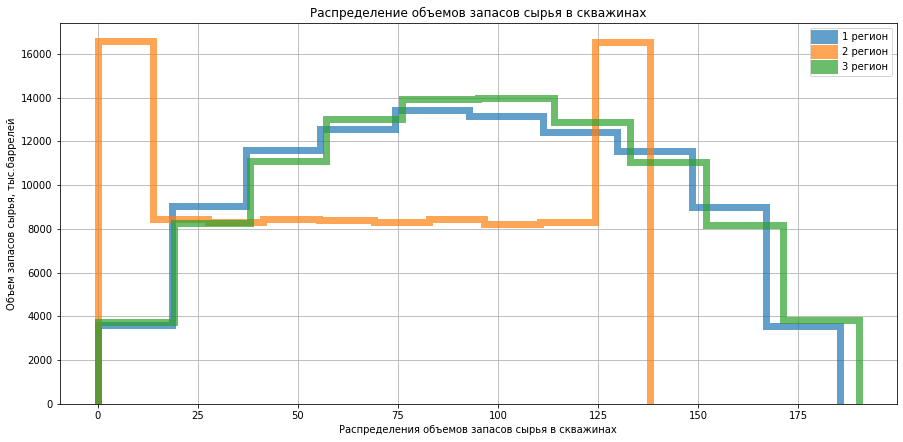

In [9]:
plt.title('Распределение объемов запасов сырья в скважинах')

ax = geo_data_0['product'].plot(kind='hist',
                          figsize=(15,7),
                          grid=True,
                          legend=True,
                          alpha=0.7,
                          histtype='step',
                          linewidth=7,
                          label='1 регион')

ax1 = geo_data_1['product'].plot(kind='hist',
                                 figsize=(15,7),
                                 grid=True,
                                 legend=True,
                                 alpha=0.7,
                                 histtype='step',
                                 linewidth=7,
                                 label='2 регион',
                                 ax=ax)

geo_data_2['product'].plot(kind='hist',
                            figsize=(15,7),
                            grid=True,
                            legend=True,
                            alpha=0.7,
                            histtype='step',
                            linewidth=7,
                            label='3 регион',
                            ax=ax1)

plt.xlabel('Распределения объемов запасов сырья в скважинах')
plt.ylabel('Объем запасов сырья, тыс.баррелей')
plt.show()


### Вывод по анализу и обработке данных

- Изначально в каждом датафрейме по 10 000 данных, пропуски отсутствуют.
- Типы данных столбцов соответсвуют вложенной информации. 
- Дубликатов в исходных таблиц нет.
- Удалены строки с аномально повторяющимися id скважин.

- На графике распределения объемов запаса сырья видно, что первый и третий регион следуют нормальному распределению и схожи между собой, в то время как второй регион распределен нетипично. Вероятно, различия будут заметны и при результатах исследования рисков и прибыльности объектов регионов. 

## Обучение и проверка модели <a class="anchor" id="chapter2"></a>

**Необходимо обучить и проверить модель для каждого региона:**
   - Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
   - Обучить модель и сделать предсказания на валидационной выборке.
   - Сохранить предсказания и правильные ответы на валидационной выборке.
   - Напечатать на экране средний запас предсказанного сырья и RMSE модели.
   - Проанализировать результаты.

### Разбиение данных

1. Разбиение исходных данных на две выборки:
- обучающую (train);
- валидационную (val);
2. Параметр (random_state) выбран равным 12345.
3. Объявление четырех переменных:
- признаки: x_train, x_val;
- целевой признак: y_train, y_val.
4. Разделение на 2 выборки будет происходить в соотнешении 75:25. Для равномерного распределения  функции train_test_split задан параметр stratify=target.
5. Признак 'id' не будет используем для переменных с признаками.
   
   Признак 'id' -  уникальный идентификатор скважины - не несет в себе потенциальную информацию для предсказания объёма запасов в новых скважинах. 

In [10]:
features = ['f0', 'f1', 'f2']
target = ['product']

In [11]:
x1 = geo_data_0[features]
y1 = geo_data_0[target]

x2 = geo_data_1[features]
y2 = geo_data_1[target]

x3 = geo_data_2[features]
y3 = geo_data_2[target]

**Проверка на мультиколлинеарность признаков**

Ситуация мультиколлинеарности возникает, когда две независимые переменные имеют сильную корреляцию.

Поскольку существует сильная взаимосвязь, определение значимых переменных будет сложной задачей. Может произойти переобучение, и точность модели изменится в зависимости от набора данных.

In [12]:
def correlations(x1):
    upp_mat = np.triu(x1.corr())
    fig, ax = plt.subplots(figsize=(15, 5))

    sns.heatmap(x1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
    plt.title('Тепловая карта корреляций признаков')
    
    plt.show()
    display(x1.head())

region 1


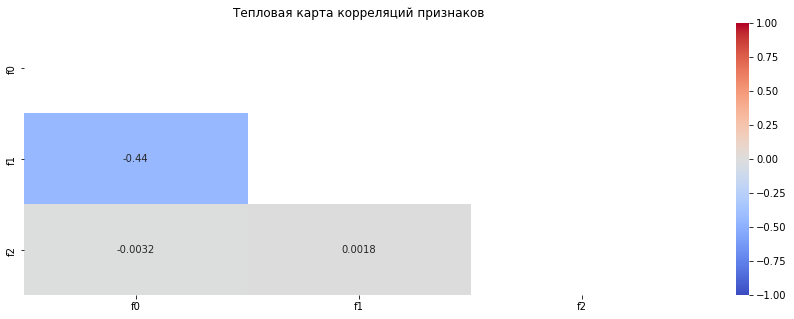

,f0,f1,f2
0,0.705745,-0.497823,1.221170
1,1.334711,-0.340164,4.365080
2,1.022732,0.151990,1.419926
3,-0.032172,0.139033,2.978566
4,1.988431,0.155413,4.751769



 region 2


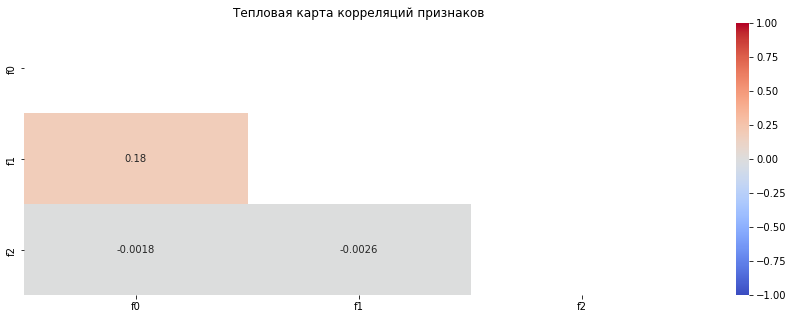

,f0,f1,f2
0,-15.001348,-8.276000,-0.005876
1,14.272088,-3.475083,0.999183
2,6.263187,-5.948386,5.001160
3,-13.081196,-11.506057,4.999415
4,12.702195,-8.147433,5.004363



 region 3


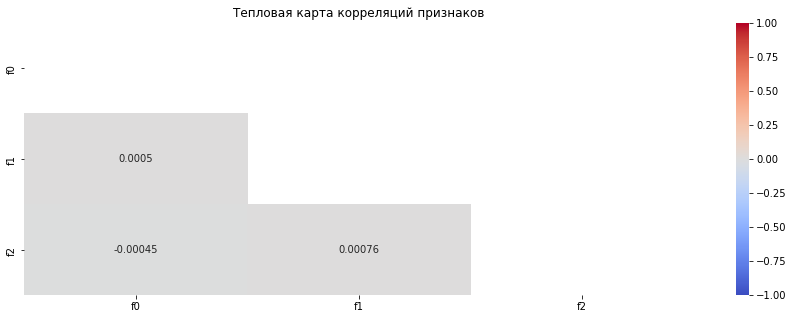

,f0,f1,f2
0,-1.146987,0.963328,-0.828965
1,0.262778,0.269839,-2.530187
2,0.194587,0.289035,-5.586433
3,2.236060,-0.553760,0.930038
4,-0.515993,1.716266,5.899011


In [13]:
print('region 1')
correlations(x1)
print('\n', 'region 2')
correlations(x2)
print('\n', 'region 3')
correlations(x3)

Независимые признаки не имеют высокую коллинеарность. 

**создание валидационной и обучающей выборок**

In [14]:
# создание валидационной и обучающей выборок
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x1, y1, test_size=0.25, random_state=12345)

x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x2, y2, test_size=0.25, random_state=12345)

x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(x3, y3, test_size=0.25, random_state=12345)

#вывод на экран размер таблиц
print('размер x_train_1, x_val_1:', x_train_1.shape[0], x_val_1.shape[0])
print('размер x_train_2, x_val_2:', x_train_2.shape[0], x_val_2.shape[0])
print('размер x_train_3, x_val_3:', x_train_3.shape[0], x_val_3.shape[0])

размер x_train_1, x_val_1: 74985 24995
размер x_train_2, x_val_2: 74994 24998
размер x_train_3, x_val_3: 74994 24998


### Стандартизация данных

**Стандартизация** – это метод масштабирования, при котором данные не масштабируются путем преобразования статистического распределения данных в следующий формат: 
- среднее – 0 (ноль);
- стандартное отклонение – 1.

Для стандартизации используется функция StandardScaler() библиотеки sklearn.

In [15]:
#функция для стандартизации данных

def scaler(x_train, x_val):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train),
                           columns=x_train.columns,
                           index=x_train.index)
    x_val = pd.DataFrame(scaler.transform(x_val),
                         columns=x_val.columns,
                         index=x_val.index)
    return x_train, x_val

In [16]:
x_train_1, x_val_1 = scaler(x_train_1, x_val_1)
x_train_2, x_val_2 = scaler(x_train_2, x_val_2)
x_train_3, x_val_3 = scaler(x_train_3, x_val_3)

### Обучение моделей

**Условие:** Для обучения модели подходит только линейная регрессия

В sklearn есть несколько классов, реализующих линейную регрессию:

- **LinearRegression** — «классическая» линейная регрессия с оптимизацией MSE.
- **Ridge** — линейная регрессия с оптимизацией MSE и ℓ2-регуляризацией
- **Lasso** — линейная регрессия с оптимизацией MSE и ℓ1-регуляризацией

In [17]:
model_table =pd.DataFrame(index=['model_lr_reg1', 'model_lr_reg2', 'model_lr_reg3',
                                 'model_ridge_reg1', 'model_ridge_reg2', 'model_ridge_reg3',
                                 'model_lasso_reg1', 'model_lasso_reg2', 'model_lasso_reg3'
                                ],columns=['r2', 'mae', 'rmse', 'pred_product_mean'])
model_table 

,r2,mae,rmse,pred_product_mean
model_lr_reg1,NaN,NaN,NaN,NaN
model_lr_reg2,NaN,NaN,NaN,NaN
model_lr_reg3,NaN,NaN,NaN,NaN
model_ridge_reg1,NaN,NaN,NaN,NaN
model_ridge_reg2,NaN,NaN,NaN,NaN
model_ridge_reg3,NaN,NaN,NaN,NaN
model_lasso_reg1,NaN,NaN,NaN,NaN
model_lasso_reg2,NaN,NaN,NaN,NaN
model_lasso_reg3,NaN,NaN,NaN,NaN


In [18]:
def model_train(x_train, y_train, x_val, y_val, model, model_name):
    model.fit(x_train, y_train)

    y_pred_val = model.predict(x_val)
    
    r2 = round(r2_score(y_val, y_pred_val), 3)
    mae = round(mean_absolute_error(y_val, y_pred_val), 3)
    rmse = round(mse(y_val, y_pred_val)**(.5), 3)
    
    model_table.loc[model_name,'r2'] = r2
    model_table.loc[model_name,'mae'] = mae
    model_table.loc[model_name,'rmse'] = rmse
    model_table.loc[model_name,'pred_product_mean'] = round(y_pred_val.mean()*1000,2)

#### LinearRegression

In [19]:
model_lr = LinearRegression()

In [20]:
model_train(x_train_1, y_train_1, x_val_1, y_val_1, model_lr, 'model_lr_reg1')
model_train(x_train_2, y_train_2, x_val_2, y_val_2, model_lr, 'model_lr_reg2')
model_train(x_train_3, y_train_3, x_val_3, y_val_3, model_lr, 'model_lr_reg3')
model_table

,r2,mae,rmse,pred_product_mean
model_lr_reg1,0.277,31.109,37.717,92423.84
model_lr_reg2,1.0,0.718,0.891,68983.12
model_lr_reg3,0.196,32.777,39.976,95116.22
model_ridge_reg1,NaN,NaN,NaN,NaN
model_ridge_reg2,NaN,NaN,NaN,NaN
model_ridge_reg3,NaN,NaN,NaN,NaN
model_lasso_reg1,NaN,NaN,NaN,NaN
model_lasso_reg2,NaN,NaN,NaN,NaN
model_lasso_reg3,NaN,NaN,NaN,NaN


#### Ridge

**Функция для перебора гиперпараметров c испспользованием GridSearchCV()**

In [21]:
def model_ridge(x_train, y_train):
    
    model = Ridge(random_state=12345)
    params =  {
        'solver':['svd', 'cholesky', 'lsqr', 'sag'],
        'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'fit_intercept':[True, False],
        'normalize':[True, False]
    }

    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        cv=5,
                        n_jobs=1,
                        verbose=2,
                        scoring='neg_root_mean_squared_error')

    grid.fit(x_train, y_train)

    return grid.best_params_

#Нахождение гиперпараметров для первого региона
model_ridge(x_train_1, y_train_1)

**Вывод: alpha = 100,
                         fit_intercept = True,
                         normalize = False,
                         solver = 'sag'**

#Нахождение гиперпараметров для второго региона
model_ridge(x_train_2, y_train_2)

**Вывод: alpha = 0.01,
                         fit_intercept = True,
                         normalize = False,
                         solver = 'svd'**

#Нахождение гиперпараметров для третьего региона
model_ridge(x_train_3, y_train_3)

**Вывод: alpha = 0.0001,
                         fit_intercept = True,
                         normalize = True,
                         solver = 'sag'**

In [22]:
model_ridge_reg1 = Ridge(random_state=12345,
                         alpha = 100,
                         fit_intercept = True,
                         normalize = False,
                         solver = 'sag')
model_ridge_reg2 = Ridge(random_state=12345,
                         alpha = 0.01,
                         fit_intercept = True,
                         normalize = False,
                         solver = 'svd')
model_ridge_reg3 = Ridge(random_state=12345,
                         alpha = 0.0001,
                         fit_intercept = True,
                         normalize = True,
                         solver = 'sag')

model_train(x_train_1, y_train_1, x_val_1, y_val_1, model_ridge_reg1, 'model_ridge_reg1')
model_train(x_train_2, y_train_2, x_val_2, y_val_2, model_ridge_reg2, 'model_ridge_reg2')
model_train(x_train_3, y_train_3, x_val_3, y_val_3, model_ridge_reg3, 'model_ridge_reg3')
model_table

,r2,mae,rmse,pred_product_mean
model_lr_reg1,0.277,31.109,37.717,92423.84
model_lr_reg2,1.0,0.718,0.891,68983.12
model_lr_reg3,0.196,32.777,39.976,95116.22
model_ridge_reg1,0.277,31.111,37.717,92423.99
model_ridge_reg2,1.0,0.718,0.891,68983.12
model_ridge_reg3,0.196,32.776,39.976,95115.93
model_lasso_reg1,NaN,NaN,NaN,NaN
model_lasso_reg2,NaN,NaN,NaN,NaN
model_lasso_reg3,NaN,NaN,NaN,NaN


#### Lasso

In [23]:
def model_lasso(x_train, y_train):
    
    model = Lasso(random_state=12345)
    params = {'alpha': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='neg_root_mean_squared_error',
                       cv=5,
                       return_train_score=True,
                       verbose=1)

    grid.fit(x_train, y_train)

    return grid.best_params_

#Нахождение гиперпараметров для первого региона
model_lasso(x_train_1, y_train_1)

Вывод: alpha =1e-07

#Нахождение гиперпараметров для второго региона
model_lasso(x_train_2, y_train_2)

Вывод: alpha = 1e-08

#Нахождение гиперпараметров для третьего региона
model_lasso(x_train_3, y_train_3)

Вывод: alpha = 0.1

In [24]:
model_lasso_reg1 = Ridge(random_state=12345,
                         alpha = 1e-07)
model_lasso_reg2 = Ridge(random_state=12345,
                         alpha = 1e-08)
model_lasso_reg3 = Ridge(random_state=12345,
                         alpha = 0.1)

model_train(x_train_1, y_train_1, x_val_1, y_val_1, model_lasso_reg1, 'model_lasso_reg1')
model_train(x_train_2, y_train_2, x_val_2, y_val_2, model_lasso_reg2, 'model_lasso_reg2')
model_train(x_train_3, y_train_3, x_val_3, y_val_3, model_lasso_reg3, 'model_lasso_reg3')

In [25]:
model_table 

,r2,mae,rmse,pred_product_mean
model_lr_reg1,0.277,31.109,37.717,92423.84
model_lr_reg2,1.0,0.718,0.891,68983.12
model_lr_reg3,0.196,32.777,39.976,95116.22
model_ridge_reg1,0.277,31.111,37.717,92423.99
model_ridge_reg2,1.0,0.718,0.891,68983.12
model_ridge_reg3,0.196,32.776,39.976,95115.93
model_lasso_reg1,0.277,31.109,37.717,92423.84
model_lasso_reg2,1.0,0.718,0.891,68983.12
model_lasso_reg3,0.196,32.777,39.976,95116.22


**Добавлю в столбец средний запас сырья из исходных данных** 

In [26]:
a = round(y1.mean()*1000,2)[0]
b = round(y2.mean()*1000,2)[0]
c = round(y3.mean()*1000,2)[0]

model_table.insert(3, "product_mean", [a,b,c,a,b,c,a,b,c])

In [27]:
model_table

,r2,mae,rmse,product_mean,pred_product_mean
model_lr_reg1,0.277,31.109,37.717,92499.17,92423.84
model_lr_reg2,1.0,0.718,0.891,68824.15,68983.12
model_lr_reg3,0.196,32.777,39.976,94998.77,95116.22
model_ridge_reg1,0.277,31.111,37.717,92499.17,92423.99
model_ridge_reg2,1.0,0.718,0.891,68824.15,68983.12
model_ridge_reg3,0.196,32.776,39.976,94998.77,95115.93
model_lasso_reg1,0.277,31.109,37.717,92499.17,92423.84
model_lasso_reg2,1.0,0.718,0.891,68824.15,68983.12
model_lasso_reg3,0.196,32.777,39.976,94998.77,95116.22


### Вывод по обучению и проверке моделей

In [28]:
print('Модели первого региона:')
display(model_table.iloc[[0,3,6]])

print('\n','Модели второго региона:')
display(model_table.iloc[[1,4,7]])

print('\n','Модели третьего региона:')
display(model_table.iloc[[2,5,8]])

Модели первого региона:


,r2,mae,rmse,product_mean,pred_product_mean
model_lr_reg1,0.277,31.109,37.717,92499.17,92423.84
model_ridge_reg1,0.277,31.111,37.717,92499.17,92423.99
model_lasso_reg1,0.277,31.109,37.717,92499.17,92423.84



 Модели второго региона:


,r2,mae,rmse,product_mean,pred_product_mean
model_lr_reg2,1.0,0.718,0.891,68824.15,68983.12
model_ridge_reg2,1.0,0.718,0.891,68824.15,68983.12
model_lasso_reg2,1.0,0.718,0.891,68824.15,68983.12



 Модели третьего региона:


,r2,mae,rmse,product_mean,pred_product_mean
model_lr_reg3,0.196,32.777,39.976,94998.77,95116.22
model_ridge_reg3,0.196,32.776,39.976,94998.77,95115.93
model_lasso_reg3,0.196,32.777,39.976,94998.77,95116.22


1. Для каждого региона были разработаны три модели для предсказания объема запаса сырья в скважинах. Использовались LinearRegression, Ridge и Lasso - линейные регрессии библиотеки sklearn.

2. Модели LinearRegression и Lasso показали идентичные значения по метрикам. Для первого региона модели LR и Lasso по метрике mae имеют идентичные показатели - лучше, чем модель Ridge. Для третьего региона модели Ridge показали лучшее значение в метрике mae с разницей в тысячной доле. Для второго региона показатели метрик индентичны. Для анализа воторого и третьего региона возьмем показатели метрик и предсказания моделей Ridge. Для анализа первого - показатели метрик и предсказания модели Lasso.

3. Во втором регионе модели показали значение r2=1, значение других метрик значительно выше, чем у других регионов.

   - Средний запас предсказанного сырья выше у третьего региона и равен 95115.93 с rmse = 39.976
   - Cредний запас предсказанного сырья первого региона равен 92423.84, rmse = 31.109
   - Ниже результат предсказанного сырья второго региона и равен 68983.12, rmse = 0.891

In [29]:
result = model_table.iloc[[0,4,5]][['rmse', 'pred_product_mean']]
result

,rmse,pred_product_mean
model_lr_reg1,37.717,92423.84
model_ridge_reg2,0.891,68983.12
model_ridge_reg3,39.976,95115.93


In [30]:
#Сохраняю предсказания лучших моделей по каждому региону
pred_reg1 = model_lasso_reg1.predict(x_val_1)
pred_reg2 = model_ridge_reg2.predict(x_val_2)
pred_reg3 = model_ridge_reg3.predict(x_val_3)

## Подготовка к расчёту прибыли <a class="anchor" id="chapter3"></a>

 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Необходимо подготовиться к расчёту прибыли:**
   - Все ключевые значения для расчётов сохранить в отдельных переменных.
   - Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
   - Написать выводы по этапу подготовки расчёта прибыли.

### Создание переменных

In [31]:
#Средний запас сырья в каждом регионе
product_mean_0 = a/1000
product_mean_1 = b/1000
product_mean_2 = c/1000

In [32]:
#Бюджет на разработку одной скважины, тыс.руб 
budget_per_well = BUDGET/200
budget_per_well

50000.0

### Достаточный объём. Сравнение со средним запасом в каждом регионе

In [33]:
#Достаточный объём сырья для безубыточной разработки новой скважины, тыс. баррелей  
v_suff = round(budget_per_well/COST_ONE_BAREL, 2)
v_suff

111.11

In [34]:
def profit(data, product_mean):
    print('Добавляем столбцы дохода с каждой скажины income и процент окупаемости:')
    data['income'] = round(data['product']*COST_ONE_BAREL, 2)
    data['per']=round((data['income']-budget_per_well)/budget_per_well*100, 2)
    display(data.head())
    print('Разница между достаточным объемом сырья для разработки скважины и средним значением по 1 региону:',round(v_suff-product_mean, 2),
      'тыс. баррелей')
    print('в процентах это:', round(data.per.mean(), 2), '%')

**Первый регион**

In [35]:
profit(geo_data_0, product_mean_0)

Добавляем столбцы дохода с каждой скажины income и процент окупаемости:


,id,f0,f1,f2,product,income,per
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


Разница между достаточным объемом сырья для разработки скважины и средним значением по 1 региону: 18.61 тыс. баррелей
в процентах это: -16.75 %


**Второй регион**

In [36]:
profit(geo_data_1, product_mean_1)

Добавляем столбцы дохода с каждой скажины income и процент окупаемости:


,id,f0,f1,f2,product,income,per
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


Разница между достаточным объемом сырья для разработки скважины и средним значением по 1 региону: 42.29 тыс. баррелей
в процентах это: -38.06 %


**Третий регион**

In [37]:
profit(geo_data_2, product_mean_2)

Добавляем столбцы дохода с каждой скажины income и процент окупаемости:


,id,f0,f1,f2,product,income,per
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


Разница между достаточным объемом сырья для разработки скважины и средним значением по 1 региону: 16.11 тыс. баррелей
в процентах это: -14.5 %


### Вывод

1. Все ключевые значения для расчётов сохранены в отдельные переменные.
2. Рассчитан достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей.
3. Проведено сравнение полученного объёма сырья со средним запасом в каждом регионе.
   Разница между достаточным объемом сырья для разработки скважины и средним значением:
   - по 1 региону: 18.61 тыс. баррелей, (-16.75 %)
   - по 2 региону: 42.29 тыс. баррелей, (-38.06 %)
   - по 3 региону: 16.11 тыс. баррелей, (-14.5 %)
4. Среднее количество запасов сырья в каждом регионе недостаточно для окупаемости разработки. Третий регион имеет максимально возможную окупаемость: 16.11 тыс. баррелей, (-14.5 %). 
5. Так как для разработки будут выбраны всего 200 случайных точек, предпологается, что в них могут быть скважины как с максимальным, так и с минимальным запасом сырья, следовательно, окупаемость будет сильно разниться со средним значением объема сырья. Для более точного определения финансового результата разработок скважин в регионах будет разработана функция техники Bootstrap. Таким образом, можно оценить прибыль и риски работы в каждом регионе.  


## Функция для расчёта прибыли

**Необходимо написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**
   - Выбрать скважины с максимальными значениями предсказаний. 
   - Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
   - Рассчитать прибыль для полученного объёма сырья.

По условию, после разведки региона выбираются 200 лучших для разработки скважин :

In [38]:
table = pd.DataFrame(index=['region_1', 'region_2', 'region_3'],columns=['average_income_million_rubles', 'total_stock_of_product_thousand_barrels', 'loss_probability_%'])
table

,average_income_million_rubles,total_stock_of_product_thousand_barrels,loss_probability_%
region_1,NaN,NaN,NaN
region_2,NaN,NaN,NaN
region_3,NaN,NaN,NaN


In [39]:
def income(pred, target):
    target['pred'] = pred
    product = target['pred'].sort_values(ascending=False)[:200].sum()
    revenue = product * COST_ONE_BAREL
    return revenue - BUDGET

def recap(pred, target, region):
    target['pred'] = pred
    product = target['pred'].sort_values(ascending=False)[:200].sum()
    income_pred= income(pred, target)
    table.loc[region,'total_stock_of_product_thousand_barrels'] = round(income_pred/1000,2)
    print('Суммарный запас сырья в 200 лучших скважинах:', round(product,2), 'тыс.баррелей')
    print('Прибыль для полученного объёма сырья составит:',  round(income_pred/1000,2), 'млн.рублей', '\n')   

In [40]:
print('Расчет прибыли в первом регионе:')
recap(pred_reg1,y_val_1, 'region_1')
print('Расчет прибыли во втором регионе:')
recap(pred_reg2,y_val_2, 'region_2')
print('Расчет прибыли в третьем регионе:')
recap(pred_reg3,y_val_3, 'region_3')

Расчет прибыли в первом регионе:
Суммарный запас сырья в 200 лучших скважинах: 30804.35 тыс.баррелей
Прибыль для полученного объёма сырья составит: 3861.96 млн.рублей 

Расчет прибыли во втором регионе:
Суммарный запас сырья в 200 лучших скважинах: 27744.66 тыс.баррелей
Прибыль для полученного объёма сырья составит: 2485.1 млн.рублей 

Расчет прибыли в третьем регионе:
Суммарный запас сырья в 200 лучших скважинах: 30001.74 тыс.баррелей
Прибыль для полученного объёма сырья составит: 3500.78 млн.рублей 



**Вывод**

Все три региона потенциально прибыльны.
Максимальной прогнозируемой прибылью обладает первый регион: 3861.96 млн.рублей при объеме сырья в 30804.35 тыс.баррелей.

## Расчёт прибыли и рисков

**Посчитать риски и прибыль для каждого региона:**
   - Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   - Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
   - Написать выводы: предложить регион для разработки скважин и обосновать выбор.

In [41]:
def income_(predict,target):
    predict = pd.Series(predict).sort_values(ascending=False)
    product = target[predict.index][:200].sum()
    revenue = product * COST_ONE_BAREL
    return revenue - BUDGET

In [42]:
def bootstap(pred, target, region):
    
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict = target['pred']
    target = target['product']
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predict_subsample = predict[target_subsample.index]
        values.append(income_(predict_subsample,target_subsample))

            
    values = pd.Series(values)
    per = len(values[values<0])/len(values)
    #Прибыль
    mean = values.mean()
    
    #Окупаемость инвестиций
    roi =abs(round((mean-BUDGET)/BUDGET*100, 2))
    
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(10,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    before_95 = values.quantile(0.025)
    after_95 = values.quantile(0.975)
    
    table.loc[region,'average_income_million_rubles'] = round(mean/1000, 2)
    #table.loc[region,'total_stock_of_product'] = income(pred,  target)
    table.loc[region,'loss_probability_%'] =  round(per, 2)
    
    print('Cредняя прибыль:', round(mean/1000, 2), 'млн.руб')
    print('С вероятностью 95% прибыль в данном регионе будет составлять: от', round(before_95/1000, 2), 'до', round(after_95/1000, 2), 'млн.руб')
    print('95%-ый доверительный интервал: от', round(confidence_interval[0]/1000, 2), 'млн.руб до', round(confidence_interval[1]/1000, 2))
    print ('Процент окупаемости инвестиций',  roi,'%')
    print ('Вероятность убытка',  round(per, 2),'%', '\n')

### Распределение прибыли каждого региона 

Расчет прибыли в первом регионе:


  0%|          | 0/1000 [00:00<?, ?it/s]

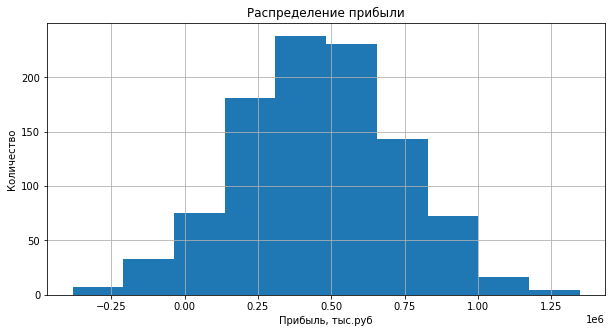

Cредняя прибыль: 459.09 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять: от -90.23 до 987.95 млн.руб
95%-ый доверительный интервал: от 442.0 млн.руб до 476.17
Процент окупаемости инвестиций 95.41 %
Вероятность убытка 0.05 % 

Расчет прибыли во втором регионе:


  0%|          | 0/1000 [00:00<?, ?it/s]

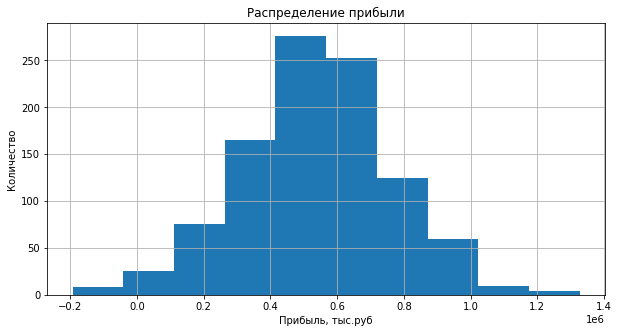

Cредняя прибыль: 535.25 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять: от 86.68 до 958.08 млн.руб
95%-ый доверительный интервал: от 521.43 млн.руб до 549.07
Процент окупаемости инвестиций 94.65 %
Вероятность убытка 0.01 % 

Расчет прибыли в третьем регионе:


  0%|          | 0/1000 [00:00<?, ?it/s]

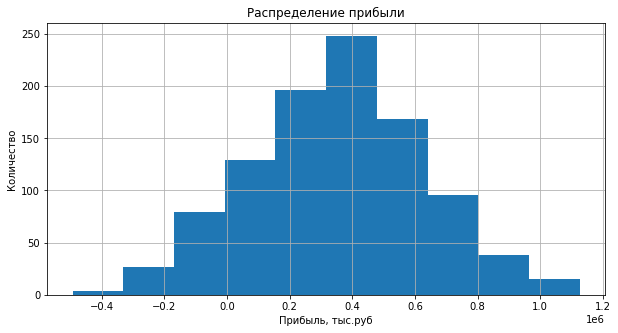

Cредняя прибыль: 351.07 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять: от -181.98 до 879.07 млн.руб
95%-ый доверительный интервал: от 333.83 млн.руб до 368.31
Процент окупаемости инвестиций 96.49 %
Вероятность убытка 0.11 % 



In [43]:
print('Расчет прибыли в первом регионе:')
bootstap(pred_reg1, y_val_1, 'region_1')
print('Расчет прибыли во втором регионе:')
bootstap(pred_reg2, y_val_2, 'region_2')
print('Расчет прибыли в третьем регионе:')
bootstap(pred_reg3, y_val_3, 'region_3')

In [44]:
table

,average_income_million_rubles,total_stock_of_product_thousand_barrels,loss_probability_%
region_1,459.09,3861.96,0.05
region_2,535.25,2485.1,0.01
region_3,351.07,3500.78,0.11


### Вывод

- Лучший регион по разработке скважины - согласно распределению среднего значения прибыли - является второй регион. 
Средняя прибыль 535.25 млн.рублей, с учетом, что общий объем сырья составил 2485,1 тыс. баррелей - меньший показатель среди остальных регионов. Процент убытка 0,01%

- Первый регион имеет среднюю прибыль в 459.09 млн.рублей, средний запас сырья 3861.96 тыс. баррелей, процент убытка 0.05%.
- Третий регион имеет среднюю прибыль в 351,07 млн.рублей, средний запас сырья 3500,78 тыс. баррелей, процент убытка 0,11%.

## Общий вывод

1. **Был проведен анализ и обработка данных:**
   - Изначально в каждом датафрейме по 10 000 данных, пропуски отсутствуют.
   - Типы данных столбцов соответсвуют вложенной информации. 
   - Дубликатов в исходных таблиц нет.
   - Удалены строки с аномально повторяющимися id скважин.
   - Составлен график распределения объемов запаса сырья. На графике видно, что первый и третий регион следуют нормальному распределению, в то время как второй регион распределен нетипично.
   
   
2. **Обучены и проверены модели для каждого региона:**
                                
       2.1. Данные разбиты на обучающую и валидационную выборки в соотношении 75:25.
       2.2. Обучены модели и сделаны предсказания на валидационной выборке:
       
       - Для каждого региона были разработаны три модели для предсказания объема запаса сырья в скважинах. Использовались LinearRegression, Ridge и Lasso - линейные регрессии библиотеки sklearn.

       - Модели LinearRegression и Lasso показали идентичные значения по метрикам. Для первого региона модели LR и Lasso по метрике mae имеют идентичные показатели - лучше, чем модель Ridge. Для третьего региона модели Ridge показали лучшее значение в метрике mae с разницей в тысячной доле. Для второго региона показатели метрик индентичны. Для анализа воторого и третьего региона возьмем показатели метрик и предсказания моделей Ridge. Для анализа первого - показатели метрик и предсказания модели Lasso.

       - Во втором регионе модели показали значение r2=1, значение других метрик значительно выше, чем у других регионов.
       - Средний запас предсказанного сырья выше у третьего региона и равен 95115.93 с rmse = 39.976
       - Cредний запас предсказанного сырья первого региона равен 92423.84, rmse = 31.109
       - Ниже результат предсказанного сырья второго региона и равен 68983.12, rmse = 0.891
   
       2.3. Сохранены предсказания и правильные ответы на валидационной выборке.
 
3. **Проведена подготовка к расчёту прибыли:** 

       3.1. Все ключевые значения для расчётов сохранены в отдельные переменные.
       3.2. Рассчитан достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей.
       3.3. Проведено сравнение полученного объёма сырья со средним запасом в каждом регионе.
          Разница между достаточным объемом сырья для разработки скважины и средним значением:
          - по 1 региону: 18.61 тыс. баррелей, (-16.75 %)
          - по 2 региону: 42.29 тыс. баррелей, (-38.06 %)
          - по 3 региону: 16.11 тыс. баррелей, (-14.5 %)
       3.4. Среднее количество запасов сырья в каждом регионе недостаточно для окупаемости разработки. Третий регион имеет максимально возможную окупаемость.
       3.5. Так как для разработки будут выбраны всего 200 случайных точек, предпологается, что в них могут быть скважины как с максимальным, так и с минимальным запасом сырья, следовательно, окупаемость будет сильно разниться со средним значением объема сырья. Для более точного определения финансового результата разработок скважин в регионах будет разработана функция техники Bootstrap. Таким образом, можно оценить прибыль и риски работы в каждом регионе.
       
4. **Создана функция для расчета прибыли** 

       - 4.1. Выбраны скважины с максимальными значениями предсказаний. 
       - 4.2. Просуммировано целевое значение объёма сырья, соответствующее этим предсказаниям.
       - 4.3. Рассчитана прибыль для полученного объёма сырья: все три региона потенциально прибыльны. Максимальной прогнозируемой прибылью обладает первый регион: 3861.96 млн.рублей при объеме сырья в 30804.35 тыс.баррелей.

5. **Проведен расчет прибыли и рисков:** 

      - Лучший регион по разработке скважины - согласно распределению среднего значения прибыли - является второй регион. Средняя прибыль 535.25 млн.рублей, с учетом, что общий объем сырья составил 2485,1 тыс. баррелей - меньший показатель среди остальных регионов. Процент убытка 0,01%
 
      - Первый регион имеет среднюю прибыль в 459.09 млн.рублей, средний запас сырья 3861.96 тыс. баррелей, процент убытка 0.05%.

      - Третий регион имеет среднюю прибыль в 351,07 млн.рублей, средний запас сырья 3500,78 тыс. баррелей, процент убытка 0,11%.